In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dmipy.core.acquisition_scheme import acquisition_scheme_from_schemefile

## NIB to numpy

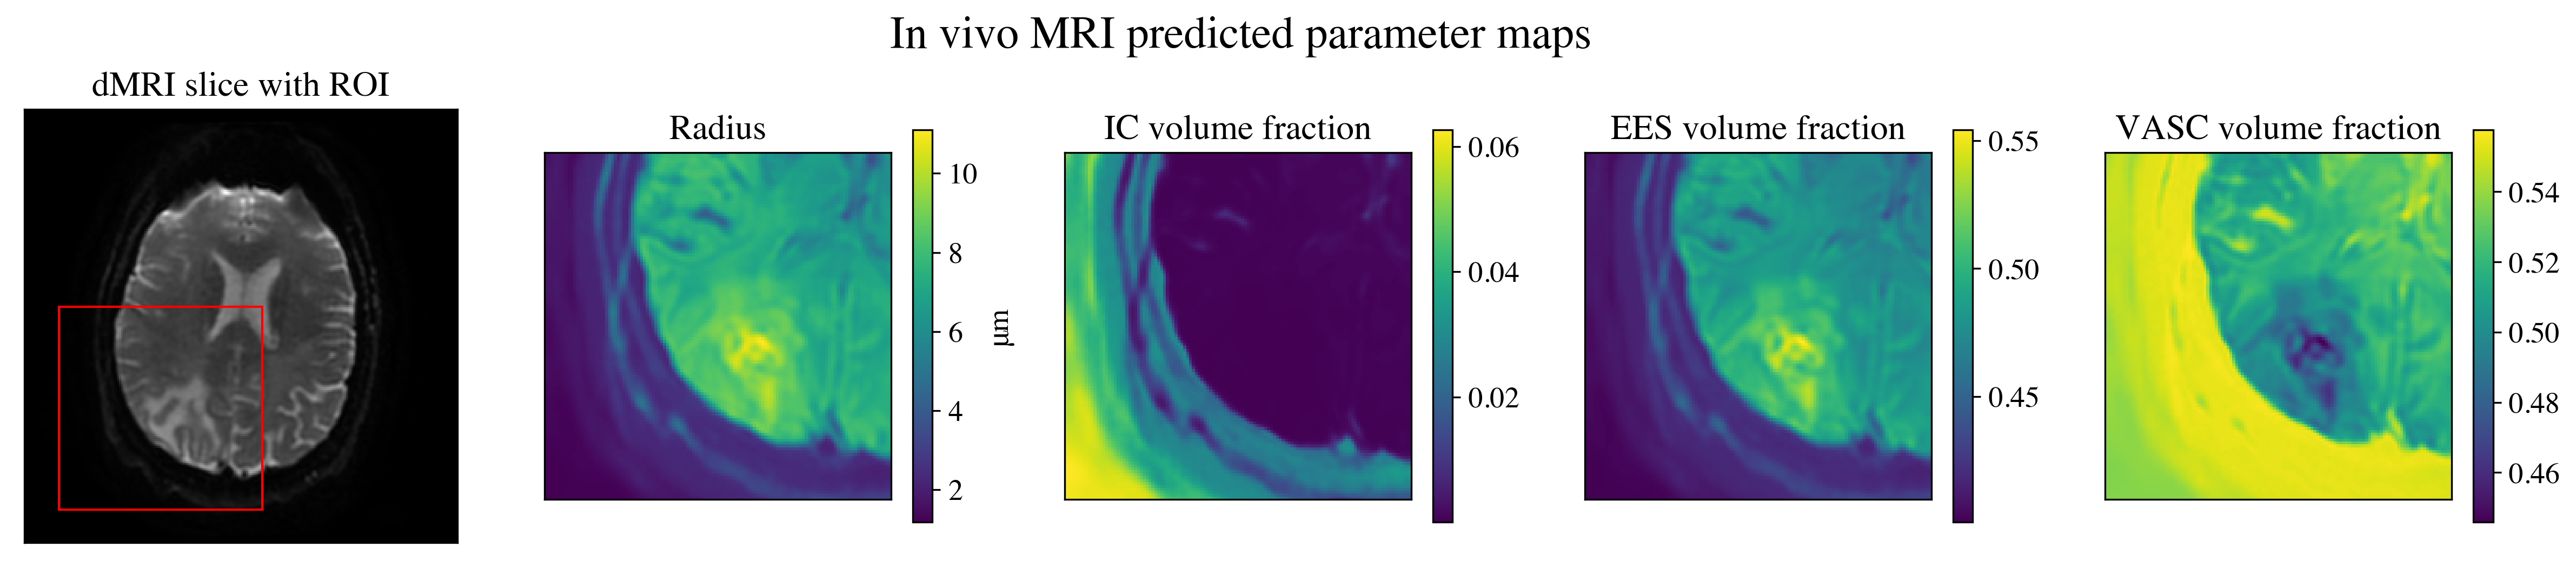

In [ ]:
import matplotlib.patches as patches

image = ndimage.rotate(data[:,:,14,100], 90)
images = [image,r*10,f_s,f_b,f_stick]
names = ["dMRI slice with ROI","Radius",'IC volume fraction','EES volume fraction','VASC volume fraction']  


plt.rcParams["font.family"] = "times"
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 13

fig = plt.figure(figsize=(20,4))


ax1 = plt.subplot2grid(shape=(1, 5), loc=(0, 0))
ax2 = plt.subplot2grid(shape=(1, 5), loc=(0, 1))
ax3 = plt.subplot2grid(shape=(1, 5), loc=(0, 2))
ax4 = plt.subplot2grid(shape=(1, 5), loc=(0, 3))
ax5 = plt.subplot2grid((1, 5), (0, 4))

axes = [ax1,ax2,ax3,ax4,ax5]

for i in range(len(axes)):

    if i == 0:
        axes[i].imshow(images[i],cmap='gray')
        rect = patches.Rectangle((20,116),120,120,linewidth=1,edgecolor='r',facecolor='none')
        axes[i].add_patch(rect)
        
    else:
        image = axes[i].imshow(ndimage.rotate(images[i],90))
        cb = fig.colorbar(image,ax=axes[i], shrink = 0.8)
        if i == 1:
            cb.set_label('\u03BCm',loc='center')
    axes[i].set_title(names[i])

    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)

fig.suptitle('In vivo MRI predicted parameter maps',fontsize=20)
plt.show()



In [25]:
import torch

def sphere_attenuation(gradient_strength, delta, Delta, radius):
    """
    Calculates the sphere signal attenuation.
    From DMIPY
    """
    SPHERE_TRASCENDENTAL_ROOTS = torch.FloatTensor([
        # 0.,
        2.081575978, 5.940369990, 9.205840145,
        12.40444502, 15.57923641, 18.74264558, 21.89969648,
        25.05282528, 28.20336100, 31.35209173, 34.49951492,
        37.64596032, 40.79165523, 43.93676147, 47.08139741,
        50.22565165, 53.36959180, 56.51327045, 59.65672900,
        62.80000055, 65.94311190, 69.08608495, 72.22893775,
        75.37168540, 78.51434055, 81.65691380, 84.79941440,
        87.94185005, 91.08422750, 94.22655255, 97.36883035,
        100.5110653, 103.6532613, 106.7954217, 109.9375497,
        113.0796480, 116.2217188, 119.3637645, 122.5057870,
        125.6477880, 128.7897690, 131.9317315, 135.0736768,
        138.2156061, 141.3575204, 144.4994207, 147.6413080,
        150.7831829, 153.9250463, 157.0668989, 160.2087413,
        163.3505741, 166.4923978, 169.6342129, 172.7760200,
        175.9178194, 179.0596116, 182.2013968, 185.3431756,
        188.4849481, 191.6267147, 194.7684757, 197.9102314,
        201.0519820, 204.1937277, 207.3354688, 210.4772054,
        213.6189378, 216.7606662, 219.9023907, 223.0441114,
        226.1858287, 229.3275425, 232.4692530, 235.6109603,
        238.7526647, 241.8943662, 245.0360648, 248.1777608,
        251.3194542, 254.4611451, 257.6028336, 260.7445198,
        263.8862038, 267.0278856, 270.1695654, 273.3112431,
        276.4529189, 279.5945929, 282.7362650, 285.8779354,
        289.0196041, 292.1612712, 295.3029367, 298.4446006,
        301.5862631, 304.7279241, 307.8695837, 311.0112420,
        314.1528990
    ])


    const = dict(
    water_diffusion_constant=2.299e-9,  # m^2/s
    water_in_axons_diffusion_constant=1.2e-9,  # m^2/s
    naa_in_axons=.00015e-9,  # m^2 / s
    water_gyromagnetic_ratio=267.513e6)  # 1/(sT)

    D = const['water_in_axons_diffusion_constant']
    gamma = const['water_gyromagnetic_ratio']
    radius = radius*1e-6# to meter .detach().numpy() #/ 2

    alpha = SPHERE_TRASCENDENTAL_ROOTS / radius
    alpha2 = torch.FloatTensor(alpha ** 2)
    alpha2D = alpha2 * D


    first_factor = -2 * (gamma * gradient_strength) ** 2 / D
    summands = (
        alpha ** (-4) / (alpha2 * radius ** 2 - 2) *
        (
            2 * delta - (
                2 +
                torch.exp(-alpha2D * (Delta - delta)) -
                2 * torch.exp(-alpha2D * delta) -
                2 * torch.exp(-alpha2D * Delta) +
                torch.exp(-alpha2D * (Delta + delta))
            ) / (alpha2D)
        )
    )
    E = torch.exp(
        first_factor *
        summands.sum(axis=0)
    )

    return E

In [5]:

def get_scheme_values(path_to_acqscheme, no_zero_values=True):
    
    scheme = acquisition_scheme_from_schemefile(path_to_acqscheme)

    b_values = scheme.bvalues
    gradient_strength = scheme.gradient_strengths
    gradient_directions = scheme.gradient_directions
    delta = scheme.delta
    Delta = scheme.Delta

    if no_zero_values:
        zero_idx = np.where(gradient_strength==0)
        b_values = torch.FloatTensor(np.delete(b_values,zero_idx))
        gradient_strength = torch.FloatTensor(np.delete(gradient_strength,zero_idx))
        gradient_directions = torch.FloatTensor(np.delete(gradient_directions,zero_idx,0))
        delta = torch.FloatTensor(np.delete(delta,zero_idx))
        Delta = torch.FloatTensor(np.delete(Delta,zero_idx))
    
    else:
        b_values = torch.FloatTensor(b_values)
        gradient_strength = torch.FloatTensor(gradient_strength)
        gradient_directions = torch.FloatTensor(gradient_directions)
        delta = torch.FloatTensor(delta)
        Delta = torch.FloatTensor(Delta)
    return b_values, gradient_strength, gradient_directions, delta, Delta

In [33]:
path_to_acqscheme = "/Users/theavage/Documents/Master/Master-project/data/3466.scheme"

b_values, g, gradient_directions, delta, Delta = get_scheme_values(path_to_acqscheme, no_zero_values=True)
i = 1
sphere_attenuation(g[i], delta[i], Delta[i], 1)


tensor(1.0000)

In [24]:
print(sphere_attenuation(g, delta, Delta, 30))

tensor([9.7147e-01, 9.7147e-01, 9.7147e-01,  ..., 1.6586e-07, 1.6586e-07,
        1.6586e-07])
